# L2 Regularization

###  Imports

In [1]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### Model

In [52]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)  
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(pred, y)
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

### Train classifier

In [53]:
num_epochs = 4
batch_size = 32
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device)

# optimizer
decay = 1e-04
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=decay)

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device))
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_loader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_loader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")


C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 : Test accuracy:  95.13000000000001 %
Epoch  1 : Test accuracy:  96.02000000000001 %
Epoch  2 : Test accuracy:  97.76 %
Epoch  3 : Test accuracy:  97.56 %
Performance in the trained model: 
Test accuracy:  97.56 %
FINISHED!!!


### Save models 

In [54]:
torch.save(cl.state_dict(), './saved_models/L2/l2_regularized_1e-04_model_4.pth')

# FGSM

### Imports

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

### Inputs

In [4]:
### ONLY RUN ONCE AT THE BEGINNING! 
# The key 0 corresponds to 0 weight decay i.e. the vanilla model with 0 prune
# fgsm_regularized = {0: [0.9766, 0.8948, 0.7273, 0.513, 0.3179, 0.1715, 0.097]}

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = './saved_models/L2/l2_regularized_1e-04_model_4.pth'
use_cuda = True

### Model under attack

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)    

        
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

### FGSM attack

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Run attack

In [27]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [28]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
print(accuracies)

C:\Users\Matach\Anaconda3\envs\fyp\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

### Results
DONT FORGET TO CHANGE THE WEIGHT DECAY KEY DICTIONARY

In [11]:
# SAVE THE ACCURACIES INTO THE CORRESPONDING WEIGHT DECAY
weight_decay = 0.001
fgsm_regularized[weight_decay] = accuracies

In [89]:
a = np.array([[0.9766, 0.8948, 0.7273, 0.513, 0.3179, 0.1715, 0.097],
[0.9833, 0.9269, 0.8139, 0.6432, 0.442, 0.2653, 0.1508] ,
[0.9764, 0.9149, 0.7944, 0.6132, 0.3927, 0.2049, 0.084],
[0.9786, 0.9164, 0.8027, 0.6301, 0.4327, 0.2578, 0.1436] ])
fgsm_regularized[0] = np.mean(a, axis=0)

In [90]:
fgsm_regularized

{0: array([0.978725, 0.91325 , 0.784575, 0.599875, 0.396325, 0.224875,
        0.11885 ]),
 0.01: array([0.97246667, 0.92153333, 0.81866667, 0.6559    , 0.45093333,
        0.24263333, 0.0982    ]),
 0.001: array([0.97925 , 0.928225, 0.8241  , 0.658475, 0.43775 , 0.231575,
        0.11175 ]),
 0.0001: array([0.98183333, 0.92376667, 0.81246667, 0.64063333, 0.44296667,
        0.28856667, 0.18126667])}

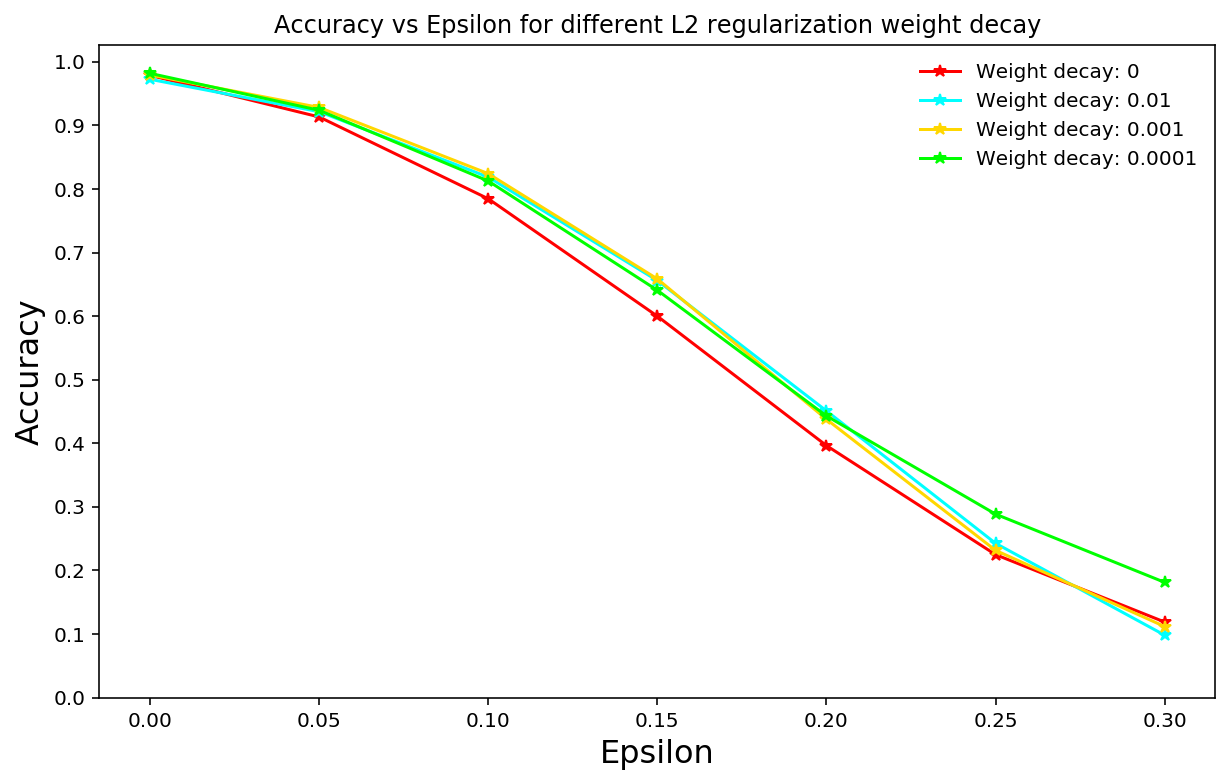

In [91]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(fgsm_regularized.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon for different L2 regularization weight decay")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

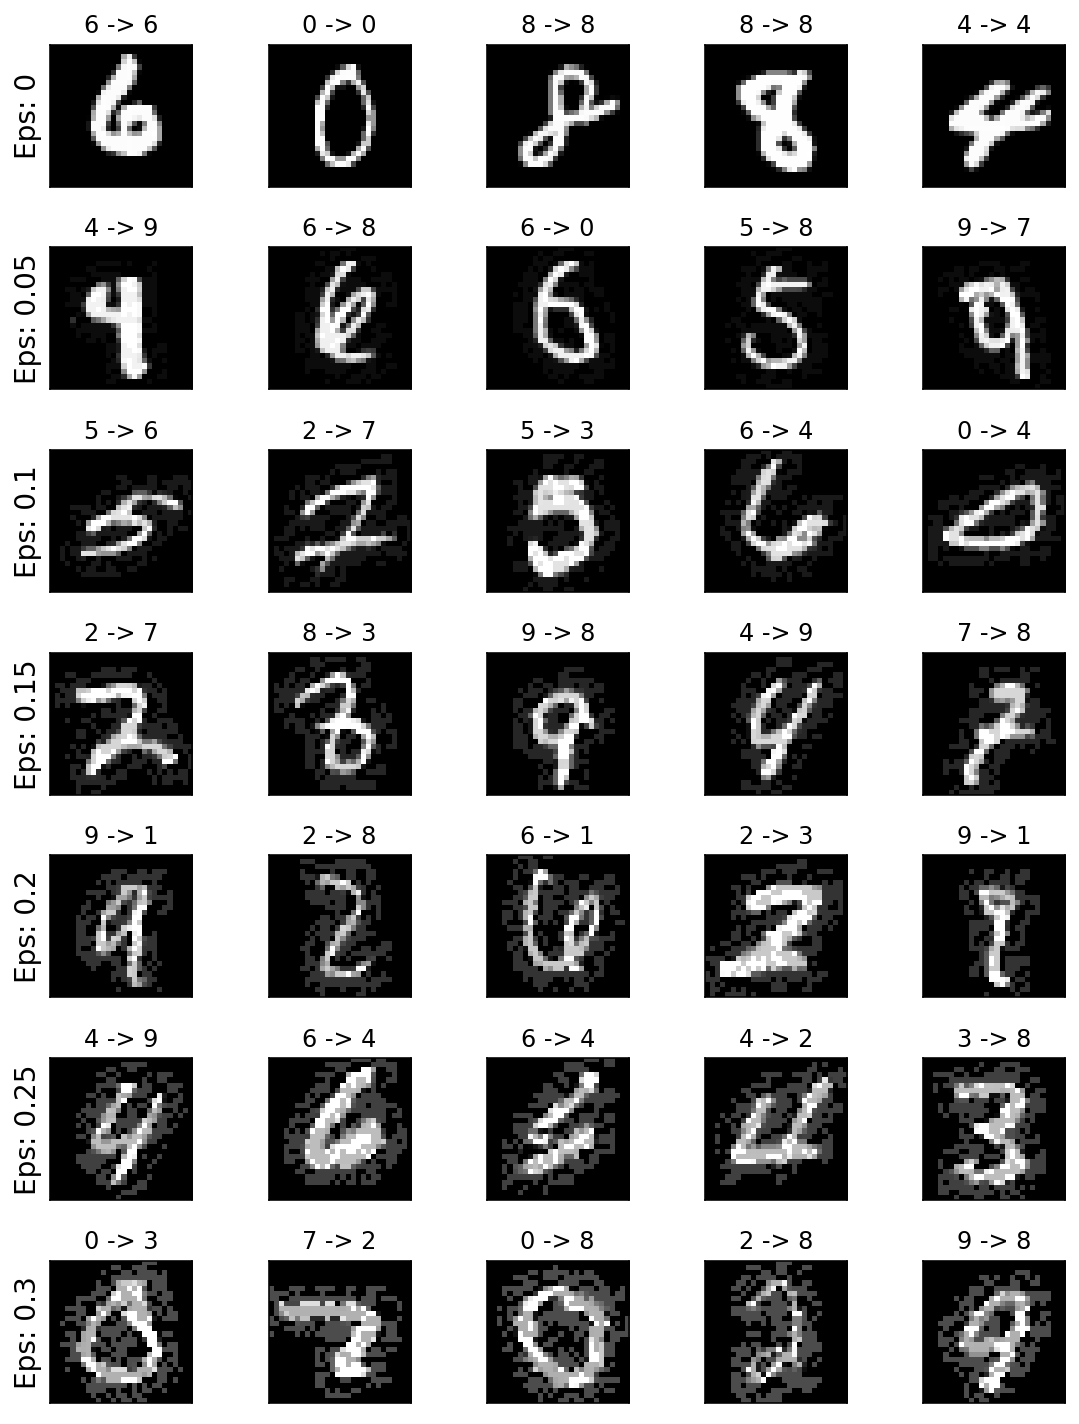

In [46]:
# Plot several examples of adversarial samples at each epsilon
### THIS SAMPLES ARE FROM THE L2 REGULARIZED MODEL OF 0.0001
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()